# Assignment 3: Maschinelles Lernen
### Ersteller: Max Otto Berth, Matrikel 808750
- M.Sc. Operations Management: Data Analysis
- Abgabedatum 18. Juli 2024

Genutzte Ressourcen zur Erstellung: 
- Vorlesungsunterlagen Data Analysis SoSe 2024
- Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und TensorFlow: Konzepte, Tools und Techniken für intelligente Systeme, Aurélien Géron, O'Reilly Verlag, 2023
- ChatGPT, Google Maps, StackOverflow, Kaggle

**Anmerkung zur Interpretation der Aufgabenstellung:**

Ich habe die Aufgabe so interpretiert, dass die Vorhersage **stundenweise** 24h im Voraus geschehen soll. Die Info ein Modell zu bauen, welches lediglich die Gesamtanzahl der Fahrräder, welche am nächsten Tag ausgeliehen werden, habe ich leider erst am 15.07. erhalten wo ich bereits fast fertig mit dem Assignment war. Bitte dies bei evtl. höheren absoluten Fehlern berücksichtigen.


## Vorgehensweise
- Problemverständnis bilden
- Datenformate säubern
- Daten in Trainings- und Testdaten teilen
- Trainingsdaten erkunden und visualisieren
- Trainingsdaten für ML-Modelle vorbereiten
- Trainingsdaten mit neuen Features anreichern (Feature Engineering)
- Datenpipeline für Testdaten vorbereiten
- ML-Modelle auswählen und trainieren
- Testdaten über Datenpipeline vorbereiten
- ML-Modelle mit den Testdaten evaluieren
- Modelle quantitativ und qualitativ vergleichen
- Bestes Modell aussuchen

# Vorbetrachtungen
### Problemtyp
- Zeitgranularität: stündlich
- finale Prognose: 24 im Voraus --> **Zeitreihenbetrachtung !!!!**
- Zielvariable = "Anzahl Fahrräder", daher handelt es sich um eine **Regressionsaufgabe**
- Zielvariable im Modell = `RentalsIn24h`

### Spezialfall: 24h-Vorhersage
- wir können also (im Vergleich zu Assignment 2) die Datensätze nicht separat betrachten (es geht nicht um die Regression auf Basis einzelner Instanzen, sondern um die Ableitung von Trends)
<br>
Weiterhin:
Die Vergangenheitswerte sind bekannt, Ziel unseres Modell mithilfe von Annahmen über die Zukunft eine Vorhersage über die verliehenen Fahrräder machen.
- es bleibt die Frage was überhaupt als Testdaten in Frage kommt, da ja nicht willkürlich ganze Tage aus dem Datensatz entfernt werden können (Zerstörung Zeitreihenkonsistenz + absolutes Overfitting, da das Modell nach dem Training ein Großteil der Werte gesehen hat)
<br>
--> herkömmliches Trainings-/Testdatensplitting wie mit `sklearn.model_selection.train_test_split` oder `sklearn.model_selection.StratifiedShuffleSplit` kommt hier also nicht in Frage

### Zeitbasierter Trainings- und Testdatensplit
Durch den Zeitreihencharakter des Problems kommt ausschließlich ein zeitbasierter Split in Frage.
1. Trainingssatz: 2022-12-11 bis 2023-10-22 (etwa 10 Monate Daten)
2. Testsatz: 2023-10-11 bis 2023-12-11 (ca. 2 Monate Daten)

### Annahmen
Natürlich könnte man im Folgenden mit speziellen Modellen für Zeitreihen arbeiten. Da diese jedoch weder im Assignment noch im Unterricht erwähnt wurden, wird darauf verzichtet und später mittels Feature Engineering versucht, fortlaufende Vergangenheitswerte (hier: Lag Features) in die Datenpipeline einzuarbeiten.

### Resultierende Datenkonstruktion
- $X_{t0} : \text{Vergangenheitswerte + Eingangsvariablen} \\$
- ${Y}_{t0} \in X_{t0}: \text{aktuell ausgeliehene Fahrräder als Teil der Eingangsvariablen} \\$
- ${Y}_{t+24h}: \text{Zielvariable} \\$

### Unternehmen
Das Modell wird für "ein Unternehmen das in Großstädten *(plural!)* Fahrräder verleiht" erstellt. Es könnte also sein, das auch die Daten in verschiedenen *(deutschen?)* Städten erhoben wurden. Für "klassische" Fahrradverleihe ist es eher unüblich als Kette in mehreren Städten zu agieren, da es sich meist um lokale Geschäfte oder Nebengeschäftstätigkeiten von Fahrradverkäufern handelt. Daher kann man davon ausgehen, dass die Daten über Bike-Sharing Systeme wie z.B. Nextbike oder Deutsche Bahn Connect, als einzige Geschäftsmodelle in Deutschland mit Tätigkeiten in mehreren Städten, erhoben wurden. Die Tatsache, dass die Fahrräder 24/7 ausgeliehen werden bekräftigt diese Vermutung.
<br><br>
Da es sich also um ein KMU (ohne konkreten Fokus auf IT) handelt, sollte das Modell also möglichst gut verständlich sein und evtl. ein Interface zur Ausgabe der Prognosen haben. Es kann davon ausgegangen werden, dass die Nutzer dieses Modells keine Machine Learning Experten sind.

# Datenbasis

In [347]:
import pandas as pd
import warnings
# We are in bold mode, so we don't care about non-crucial warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def fetch_bike_rental_data():
    # Read the CSV file, specifying the delimiter and converting European decimal commas to points
    file_path = 'assignment3.csv'
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    
    # Immediate corrections and enrichment
    df['Datum'] = pd.to_datetime(df['Datum'])
    numeric_cols = df.columns.drop(['Datum', 'Normalhreszeit', 'Ferienzeit', 'Verkehrslage'])
    df[numeric_cols] = df[numeric_cols].astype(float)

    # Enrich columns with information from assignment task
    df.rename(
        columns = {
            'Datum': 'Datum [Tag und Stunde]',
            'Temperatur': 'Temperatur [°C]',
            'Luftfeuchtigkeit': 'Luftfeuchtigkeit [%]',
            'Wind': 'Windgeschwindigkeit [m/s]',
            'Sicht': 'Sichtweite [m]',
            'Taupunkt': 'Taupunkt [°C]',
            'Sonneneinstrahlung': 'Sonneneinstrahlung [Lux]',
            'Regenmenge': 'Regenmenge [mm]',
            'Schneemenge': 'Schneemenge [mm]',
            'Normalhreszeit': 'Jahreszeit',
            'Ferienzeit': 'Ferienzeit [Ja=1/Nein=0]',
            'Verkehrslage': 'Verkehrslage [Normal=1/Sperrungen=0]',
            'Anzahl Fahrräder': 'Anzahl ausgeliehener Fahrräder'
            },
        inplace=True
        )
    
    # Convert categorical values
    df['Verkehrslage [Normal=1/Sperrungen=0]'] = df['Verkehrslage [Normal=1/Sperrungen=0]'].map({'Normal': 1, 'Sperrungen': 0})
    df['Ferienzeit [Ja=1/Nein=0]'] = df['Ferienzeit [Ja=1/Nein=0]'].map({'Ferien': 1, 'Keine Ferien': 0})
    df['Jahreszeit'] = df['Jahreszeit'].map(
        {
            'Frühling': 1,
            'Sommer': 2,
            'Herbst':3,
            'Winter':4
            }
        )
    # df = pd.get_dummies(df, columns=['Jahreszeit'])

    # df[
    #     [
    #         "Jahreszeit_Frühling",
    #         "Jahreszeit_Herbst",
    #         "Jahreszeit_Sommer",
    #         "Jahreszeit_Winter"
    #         ]
    #         ] = df[
    #             [
    #                 "Jahreszeit_Frühling",
    #                 "Jahreszeit_Herbst",
    #                 "Jahreszeit_Sommer",
    #                 "Jahreszeit_Winter"
    #                 ]
    #                 ].astype(int)

    return df

def show_unique_values(df):
    unique_counts = df.nunique()
    print("Column Name | Number of Unique Values")
    print("--------------------------------------")
    for column, count in unique_counts.items():
        print(f"{column:<15} | {count}")

df = fetch_bike_rental_data()
display(df.head())
display(df.info())
show_unique_values(df)

def check_for_completeness(dfi):
    # Resample data by day and count rows
    df = dfi.copy()
   
    df.set_index('Datum [Tag und Stunde]', inplace=True)

    daily_counts = df.resample('D').size()
    print("Days in Dataset: ",daily_counts.shape[0])
    
    # Check if all days have exactly 24 rows
    days_with_24_hours = daily_counts[daily_counts == 24]

    # Print days where there are not exactly 24 rows
    days_with_less_than_24_hours = daily_counts[daily_counts < 24]
    days_with_more_than_24_hours = daily_counts[daily_counts > 24]

    print("Days with exactly 24 hours:")
    print(days_with_24_hours.shape)
    print(days_with_24_hours.index)

    print("\nDays with less than 24 hours:")
    print(days_with_less_than_24_hours.shape)
    print(days_with_less_than_24_hours.index)

    print("\nDays with more than 24 hours:")
    print(days_with_more_than_24_hours.shape)
    print(days_with_more_than_24_hours.index)

check_for_completeness(df)


,Datum [Tag und Stunde],Temperatur [°C],Luftfeuchtigkeit [%],Windgeschwindigkeit [m/s],Sichtweite [m],Taupunkt [°C],Sonneneinstrahlung [Lux],Regenmenge [mm],Schneemenge [mm],Jahreszeit,Ferienzeit [Ja=1/Nein=0],Verkehrslage [Normal=1/Sperrungen=0],Anzahl ausgeliehener Fahrräder
0,2022-12-11 23:00:00+00:00,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,4,0,1,254.0
1,2022-12-12 00:00:00+00:00,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,4,0,1,204.0
2,2022-12-12 01:00:00+00:00,-6.0,39.0,1.0,2000.0,-17.7,0.0,0.0,0.0,4,0,1,173.0
3,2022-12-12 02:00:00+00:00,-6.2,40.0,0.9,2000.0,-17.6,0.0,0.0,0.0,4,0,1,107.0
4,2022-12-12 03:00:00+00:00,-6.0,36.0,2.3,2000.0,-18.6,0.0,0.0,0.0,4,0,1,78.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8248 entries, 0 to 8247
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   Datum [Tag und Stunde]                8248 non-null   datetime64[ns, UTC]
 1   Temperatur [°C]                       8248 non-null   float64            
 2   Luftfeuchtigkeit [%]                  8248 non-null   float64            
 3   Windgeschwindigkeit [m/s]             8248 non-null   float64            
 4   Sichtweite [m]                        8248 non-null   float64            
 5   Taupunkt [°C]                         8248 non-null   float64            
 6   Sonneneinstrahlung [Lux]              8248 non-null   float64            
 7   Regenmenge [mm]                       8248 non-null   float64            
 8   Schneemenge [mm]                      8248 non-null   float64            
 9   Jahreszeit         

None

Column Name | Number of Unique Values
--------------------------------------
Datum [Tag und Stunde] | 8248
Temperatur [°C] | 546
Luftfeuchtigkeit [%] | 90
Windgeschwindigkeit [m/s] | 65
Sichtweite [m]  | 1770
Taupunkt [°C]   | 553
Sonneneinstrahlung [Lux] | 345
Regenmenge [mm] | 61
Schneemenge [mm] | 51
Jahreszeit      | 4
Ferienzeit [Ja=1/Nein=0] | 2
Verkehrslage [Normal=1/Sperrungen=0] | 2
Anzahl ausgeliehener Fahrräder | 2127
Days in Dataset:  366
Days with exactly 24 hours:
(97,)
DatetimeIndex(['2022-12-12 00:00:00+00:00', '2022-12-17 00:00:00+00:00',
               '2022-12-18 00:00:00+00:00', '2022-12-22 00:00:00+00:00',
               '2022-12-26 00:00:00+00:00', '2022-12-28 00:00:00+00:00',
               '2023-01-03 00:00:00+00:00', '2023-01-06 00:00:00+00:00',
               '2023-01-08 00:00:00+00:00', '2023-01-25 00:00:00+00:00',
               '2023-01-26 00:00:00+00:00', '2023-02-09 00:00:00+00:00',
               '2023-02-11 00:00:00+00:00', '2023-02-13 00:00:00+00:00',


## Erste Sichtung Datensatz
- es gibt keine NaN Werte
- mit ~8000 Einträgen relativ kleiner Datensatz, speziell bei ausschließlich tagweiser Betrachtung: unbedingt **geschichteten Train-Test-Split** anwenden!
- Jahreszeit, Ferien in 1 und 0 mappen, Verkehrslage in 1-Hot-Array umwandeln *(wird direkt weiter oben eingebaut)*
- Zeile 2596 `NA;5,4;95;1,5;89;4,6;0,00;0,0;0,0;Frühling;Keine Ferien;Normal;93` entfernt

### Sperrungen
- Verkehrslage "Sperrungen" resultiert in 0 Ausleihe (siehe: `df[df['Verkehrslage']=="Sperrungen"]['Anzahl ausgeliehener Fahrräder'].mean()`)
- treten meist in Intervallen von 6-24h auf
- problematisch, da dies das Training des Modells stark beeinträchtigen würde *und* nicht statistisch vorhergesagt werden kann
- die dadurch stark abweichenden Werte sollten später durch NaN-Behandlung ausgeglichen werden


### Vollständigkeit
- nur 97 der 366 Tage im Datensatz sind vollständig **!!!**
- dies kann zu *erheblichen* Abweichungen der Vorhersagen führen, speziell da es sich hier um eine Zeitreihenbetrachtung handelt
- bei der Anwendung des 24h-Shifts der Zielvariable ist Vorsicht geboten (besser präzises Mapping statt einfacher 24-Werte-Versatz)

## Train-Validate-Test Split
Funktionen:
- Aufteilung des Datensatzes (normalerweise: zufällig oder durch geschichteten Split) nach Datum, um den Zeitreihencharakter korrekt abzubilden
- Adaption der Zielvariable zu `RentalsIn24h` da das Modell später auf eine 24h-Vorhersage zielt

*Bis hier hin wurden am Datensatz nur sehr grundlegende Veränderungen i.S.d. Datenreinigung durchgeführt. Ab hier sollen jedoch auch für das Modell relevante Betrachtung begonnen werden, wodurch fortan nur noch mit Trainings- bzw. Validierungsdaten gearbeitet wird. Für die spätere Pipeline müssen also nur noch folgende Änderungen einbezogen werden.* 

In [348]:
import numpy as np
def split_data(df):
   # Ensure 'Datum' is in datetime format
   df['Datum [Tag und Stunde]'] = pd.to_datetime(df['Datum [Tag und Stunde]'])

   # Erstellen einer neuen Spalte mit der Anzahl der Fahrräder nach 24 Stunden = neue Target Variable
   # df['RentalsIn24h'] = df['Anzahl ausgeliehener Fahrräder'].shift(-24)
   # # df['Anzahl ausgeliehener Fahrräder'] = np.log1p(df['Anzahl ausgeliehener Fahrräder'])
   # df = df[:-24]
   df['Future_Date'] = df['Datum [Tag und Stunde]'] + pd.DateOffset(hours=24)

   # Step 3: Merge data from the future datetime
   merged = pd.merge(df, df[['Datum [Tag und Stunde]', 'Anzahl ausgeliehener Fahrräder']], 
                     left_on='Future_Date', right_on='Datum [Tag und Stunde]', 
                     suffixes=('', '_future'), how='left')

   # Step 4: Handle missing values using the median of the next day
   median_next_day = merged.groupby(merged['Datum [Tag und Stunde]'].dt.date)['Anzahl ausgeliehener Fahrräder_future'].median()
   merged['RentalsIn24h'] = merged.apply(lambda row: row['Anzahl ausgeliehener Fahrräder_future'] if pd.notna(row['Anzahl ausgeliehener Fahrräder_future']) else median_next_day[row['Datum [Tag und Stunde]'].date()], axis=1)

   # Drop unnecessary columns if needed
   merged.drop(['Future_Date', 'Datum [Tag und Stunde]_future', 'Anzahl ausgeliehener Fahrräder_future'], axis=1, inplace=True)
   
   # Assign the result back to your original dataframe if necessary
   df['RentalsIn24h'] = merged['RentalsIn24h']
   df.drop(columns=['Future_Date'],inplace=True)
   df.dropna(subset=['RentalsIn24h'], inplace=True)
   # Define split dates
   # Split the data
   train_end = '2023-10-22'
   train_df = df[df['Datum [Tag und Stunde]'] <= train_end]
   test_df = df[df['Datum [Tag und Stunde]'] > train_end]

   return train_df, test_df

train_data, test_data = split_data(df)

new_target_variable = 'RentalsIn24h'

## Wichtigkeit der Eingangsparameter

In [349]:
from sklearn.ensemble import RandomForestRegressor

def evaluate_features(dfi, target_column, no_features=5):

    df = dfi.copy()
    # Separate features and target
    most_important_features = []
    X = df.drop(columns=target_column)
    try:
        X = X.drop(columns="Datum [Tag und Stunde]")
    except Exception as e:
        pass
    y = df[target_column]
    
    # Calculate linear correlation with the target variable
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    
    print("Top 5 Linear Correlation with Target:")
    print(correlations[:no_features])
    

    # Fit a RandomForestRegressor to get feature importances
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Extract feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    most_important_features.extend(feature_importances[:no_features].index.tolist() + correlations[:no_features].index.tolist())

    print(f"\nTop {no_features} Feature Importance from Random Forest:")
    print(feature_importances[:no_features])

    return list(set(most_important_features))

top_features = evaluate_features(train_data, new_target_variable)

Top 5 Linear Correlation with Target:
Anzahl ausgeliehener Fahrräder    0.663833
Temperatur [°C]                   0.528210
Taupunkt [°C]                     0.449148
Jahreszeit                        0.338391
Sonneneinstrahlung [Lux]          0.203482
dtype: float64

Top 5 Feature Importance from Random Forest:
Anzahl ausgeliehener Fahrräder    0.518943
Temperatur [°C]                   0.128033
Sonneneinstrahlung [Lux]          0.071883
Taupunkt [°C]                     0.068461
Windgeschwindigkeit [m/s]         0.059870
dtype: float64


Höchste Einflüsse in beiden Fällen:
'Windgeschwindigkeit [m/s]',
'Sonneneinstrahlung [Lux]',
'Sichtweite [m]',
'Jahreszeit',
'Taupunkt [°C]',
'Temperatur [°C]',
'Luftfeuchtigkeit [%]'

*Bemerkung: Diese beiden Regressionen haben für die ursprüngliche Aufgabe vorerst keinerlei Bedeutung, außer das sie innerhalb des Datensatzes vorhandene Zusammenhänge beleuchten sollen.*

# Visuelle Analyse der Trainingsdaten

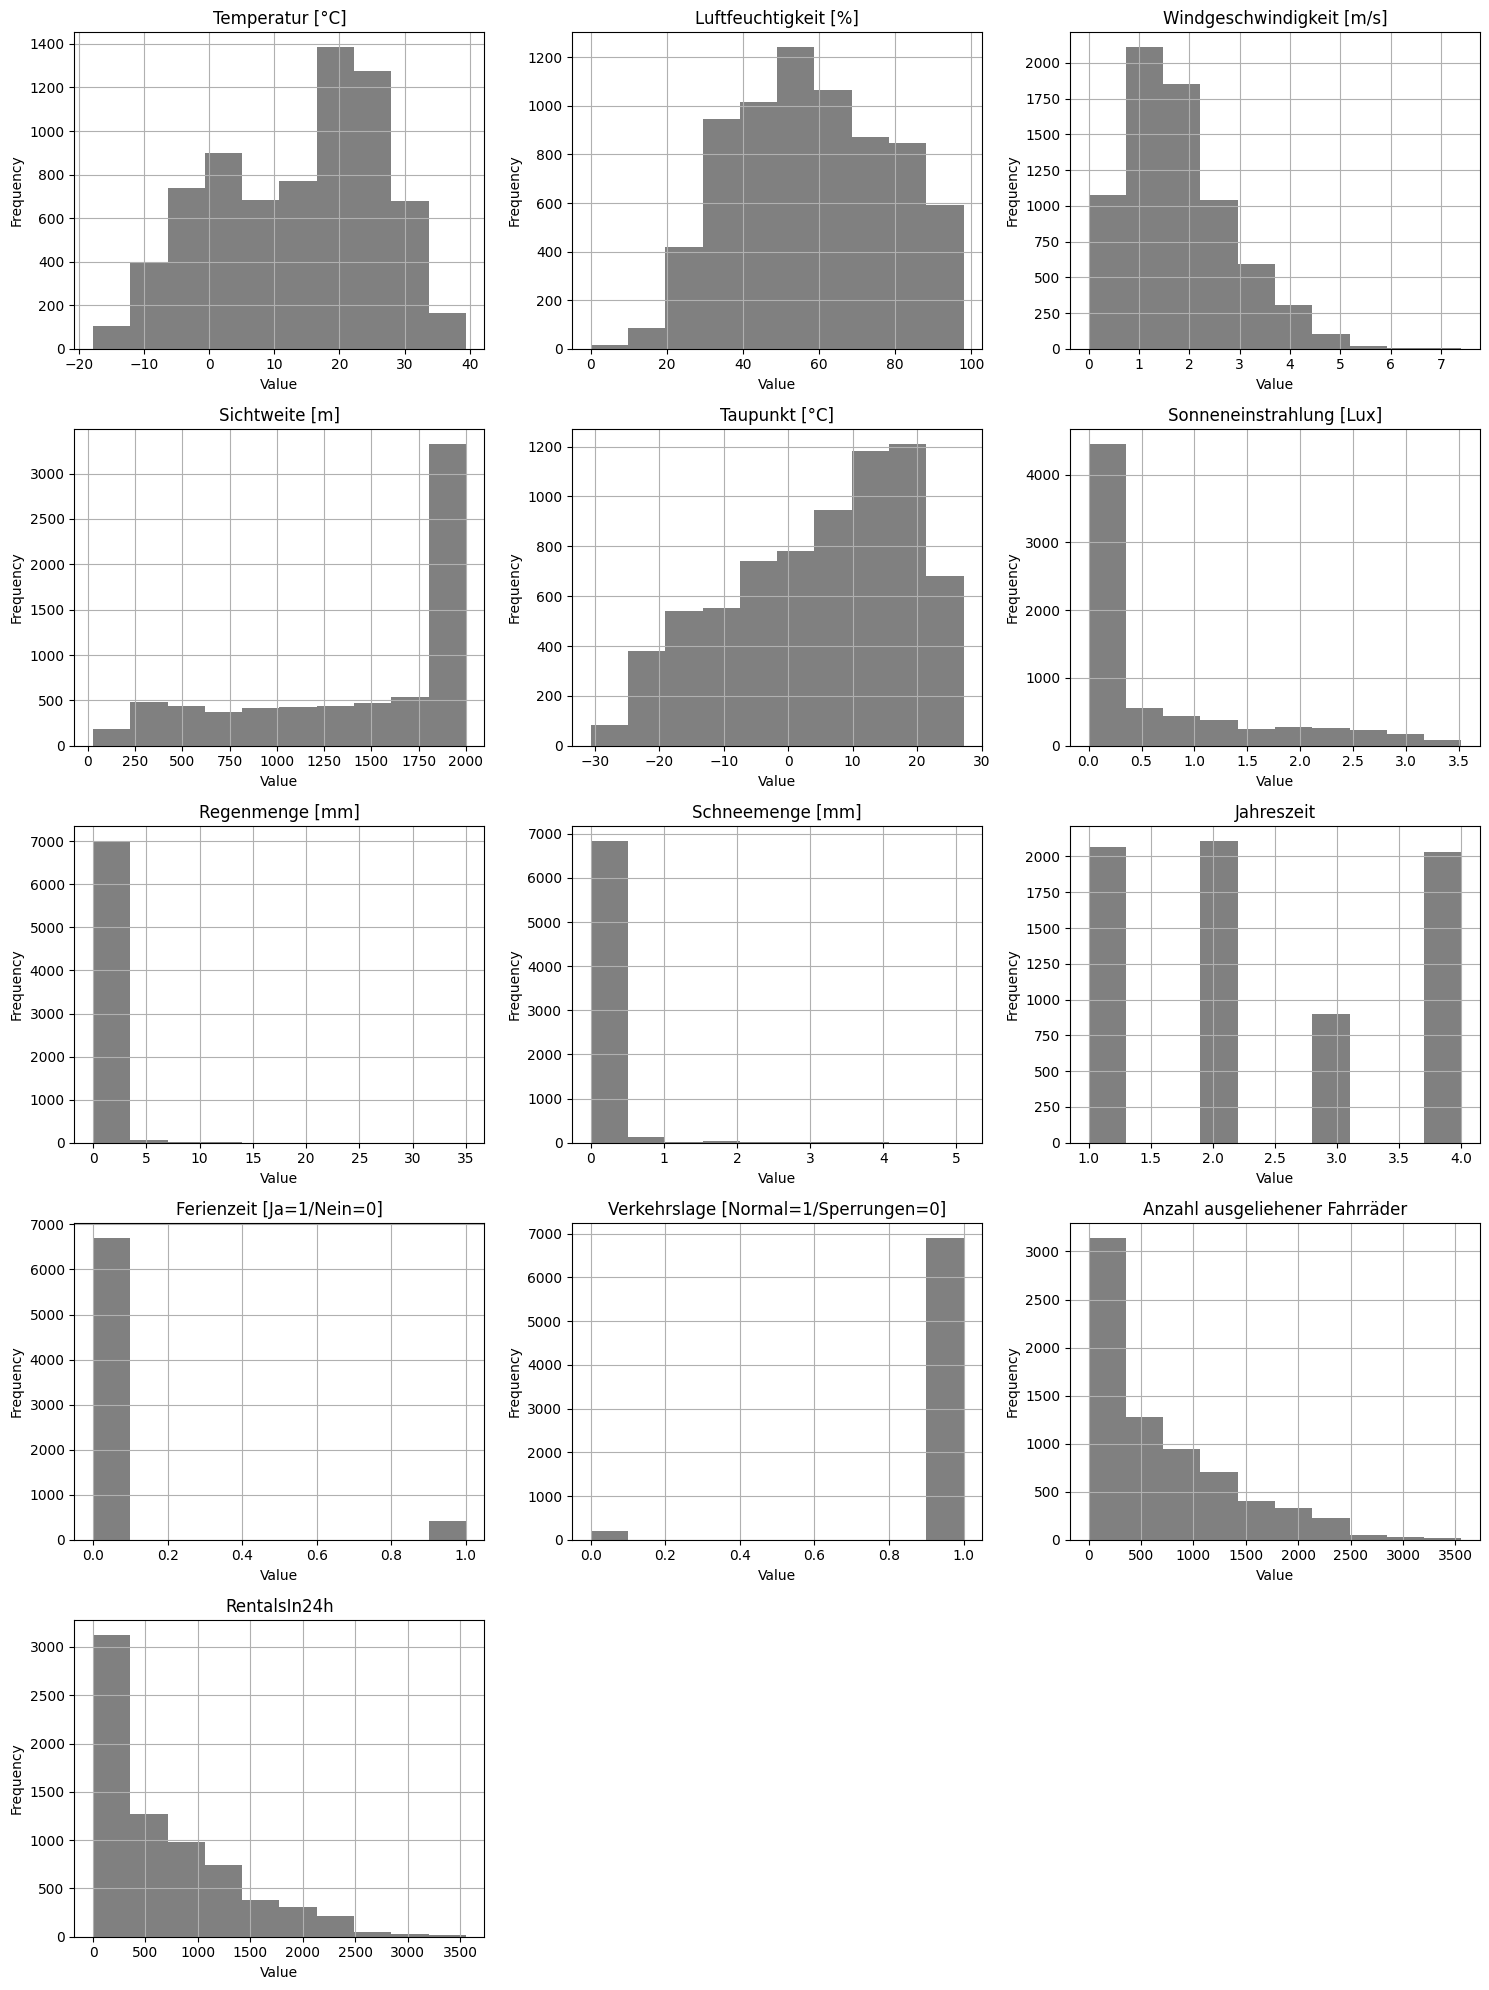

In [350]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_histograms(dfi, custom_columns=False):
    # Get the number of features

    df = dfi.copy()

    if custom_columns:
        num_features = len(custom_columns)
    else:
        num_features = len(df.columns)-1
    
    # Create a grid of subplots
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed
    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot histogram for each feature

    if custom_columns:
        columns_df = df[custom_columns]
    else:
        columns_df = df.drop(columns=["Datum [Tag und Stunde]"]).columns


    for i, column in enumerate(columns_df):
        df[column].hist(ax=axes[i], color='grey')
        axes[i].set_title(column)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage with a DataFrame 'df'
# df = pd.read_csv('your_data.csv')
plot_feature_histograms(train_data)


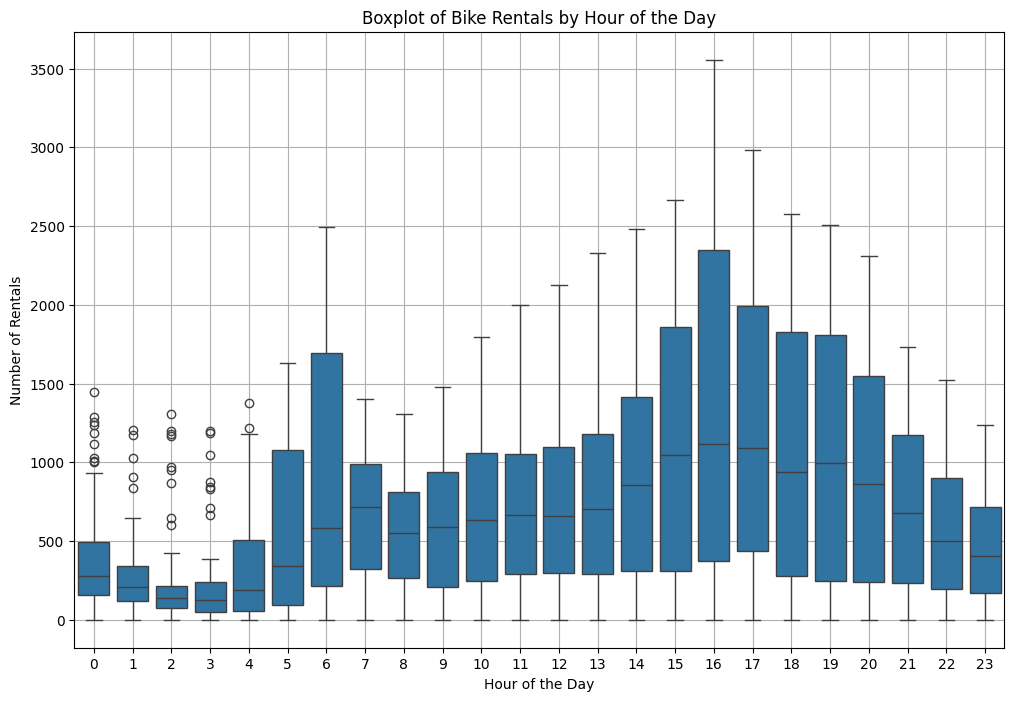

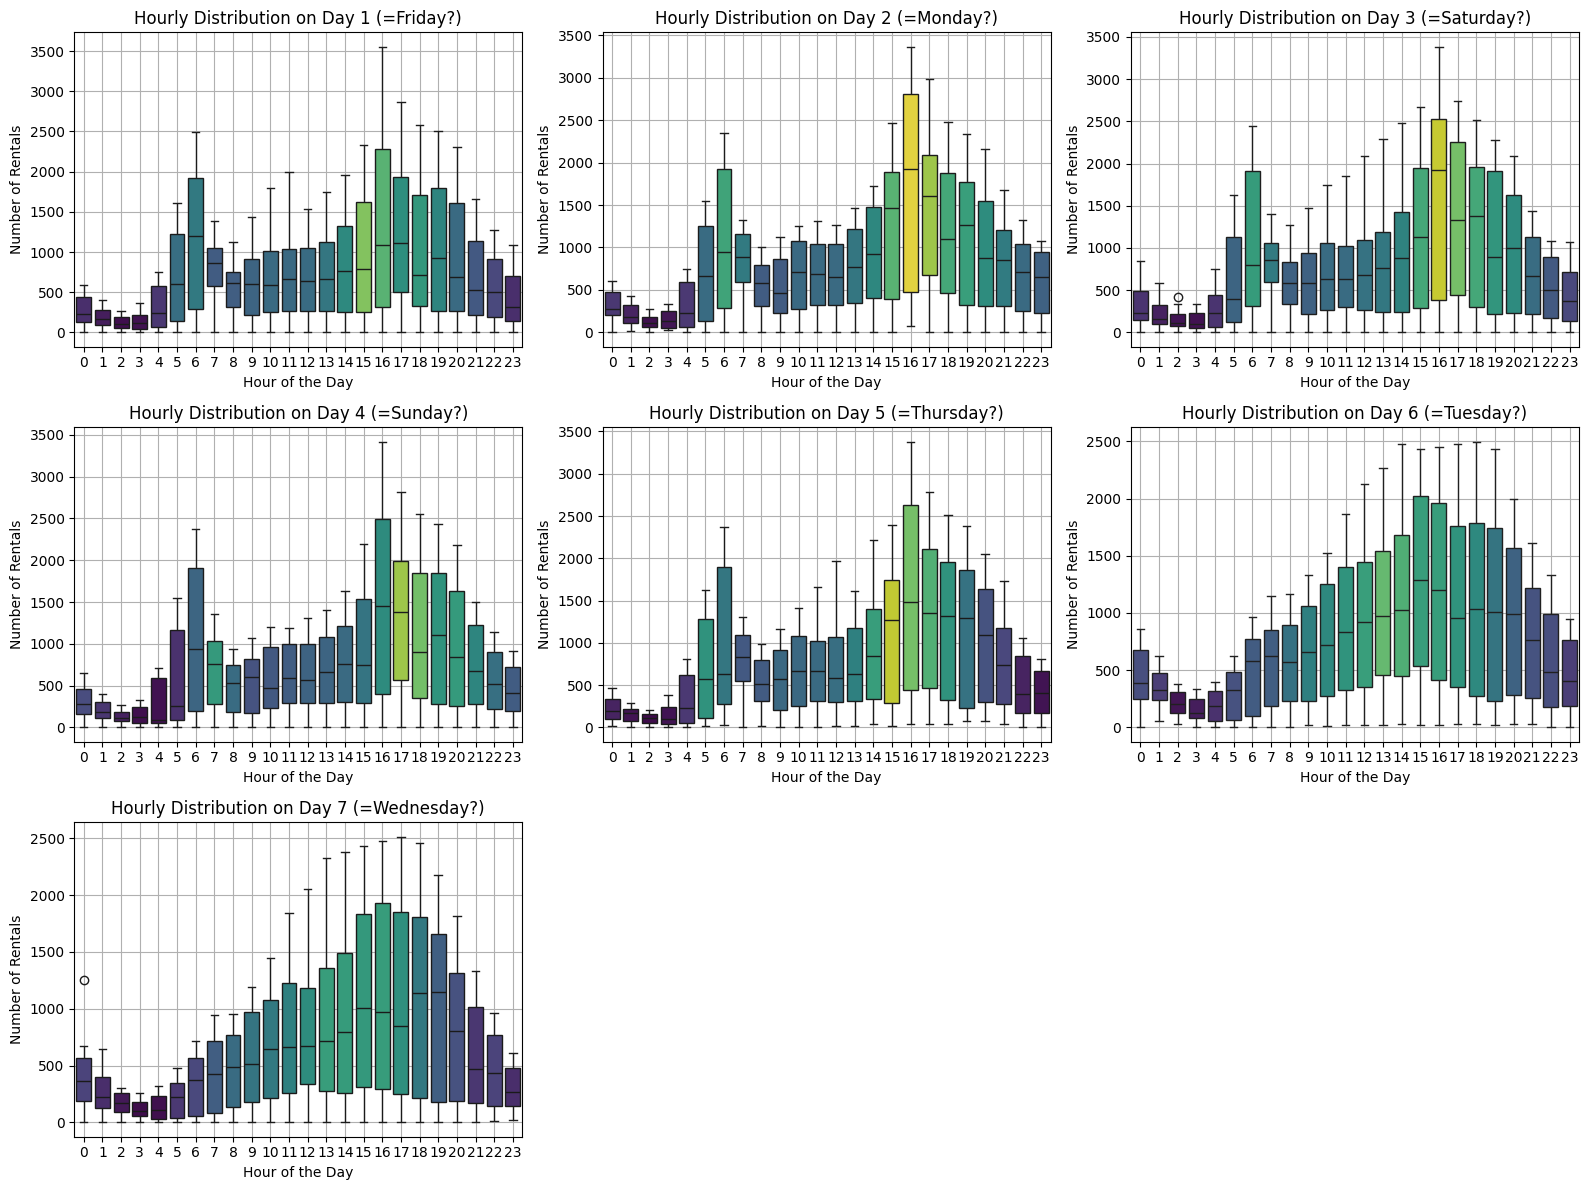

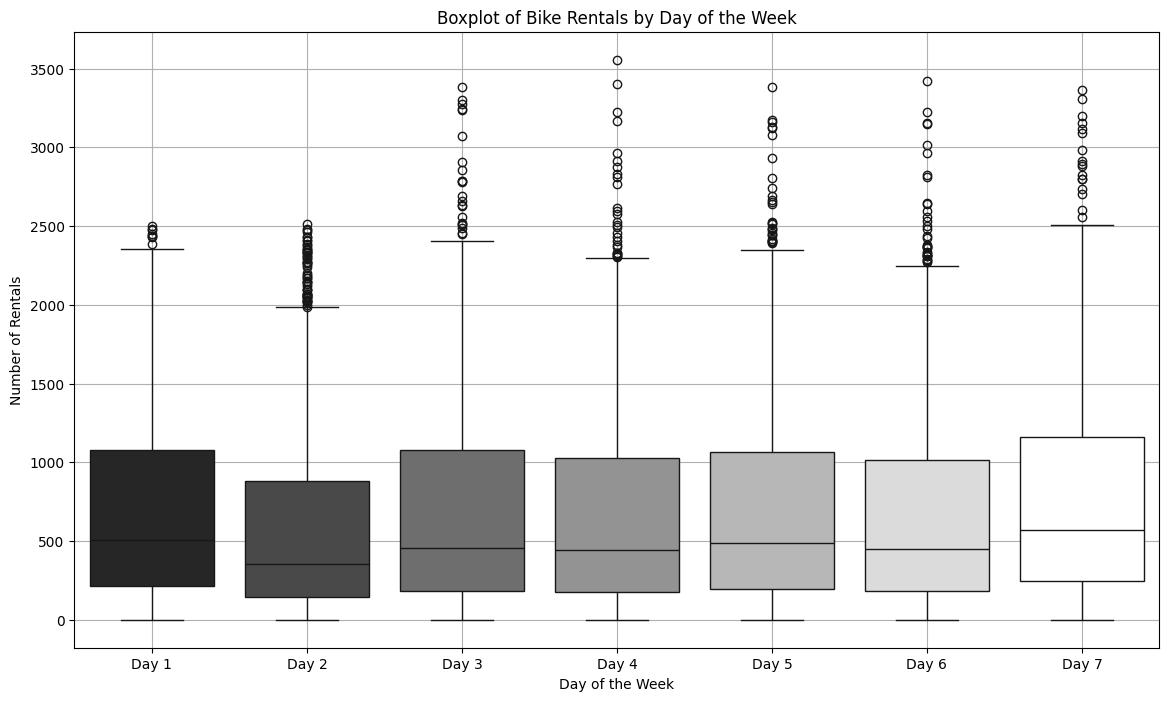

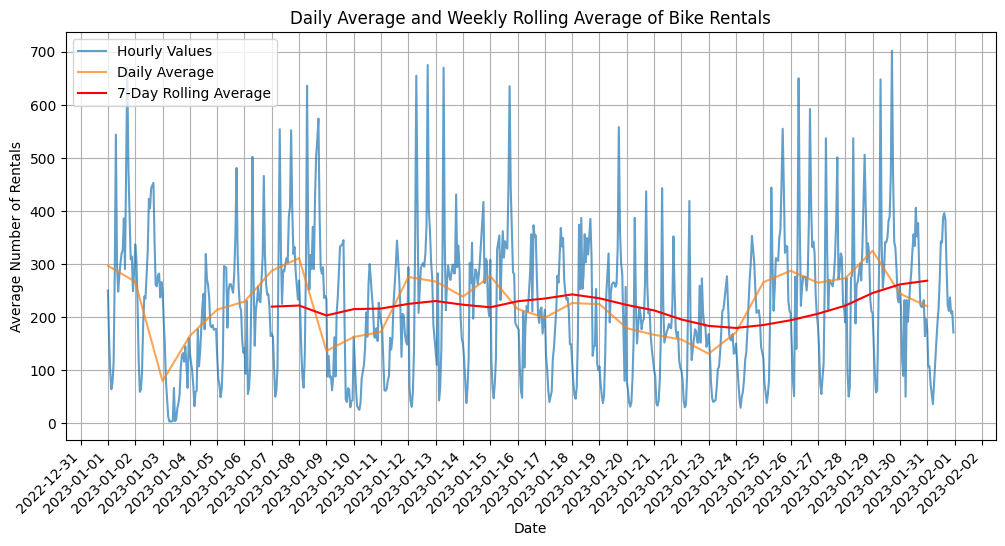

In [351]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_feature_distributions(df, day=False, week=False, weekdays=False):
    # Ensure 'Datum [Tag und Stunde]' is in datetime format
    plot_df = df.copy()

    plot_df['Datum [Tag und Stunde]'] = pd.to_datetime(plot_df['Datum [Tag und Stunde]'], errors='coerce')
    
    # Set the datetime column as index
    plot_df.set_index('Datum [Tag und Stunde]', inplace=True)

    # Plot hourly distribution if specified
    if day:
        plt.figure(figsize=(12, 8))
        sns.boxplot(x=plot_df.index.hour, y=new_target_variable, data=plot_df)
        plt.title('Boxplot of Bike Rentals by Hour of the Day')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Number of Rentals')
        plt.xticks(range(24))  # Set x-ticks to show all hours
        plt.grid(True)
        plt.show()

    if weekdays:
        # Ensure 'day_of_week' column exists; otherwise, create it
        if 'day_of_week' not in plot_df.columns:
            plot_df['day_of_week'] = plot_df.index.day_name()
        # Map days of the week to numbers 1 to 7
        day_mapping = {day: i + 1 for i, day in enumerate(pd.date_range(start='2024-01-01', periods=7, freq='D').day_name())}
        plot_df['day_of_week_numeric'] = plot_df['day_of_week'].map(day_mapping)
        
        # Calculate the average value of 'Anzahl ausgeliehener Fahrräder' for each hour and day of the week
        avg_rentals = plot_df.groupby(['day_of_week', plot_df.index.hour])["Anzahl ausgeliehener Fahrräder"].mean().unstack()
        
        # Normalize the average rentals for color mapping
        norm = plt.Normalize(avg_rentals.min().min(), avg_rentals.max().max())
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        
        # Plot hourly distribution for each weekday
        weekdays = plot_df['day_of_week'].unique()
        weekdays.sort()  # Ensure weekdays are in order
        
        plt.figure(figsize=(16, 12))
        for i, day in enumerate(weekdays):
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots (adjust as needed)
            subset = plot_df[plot_df['day_of_week'] == day]
            avg_rentals_day = avg_rentals.loc[day]
            
            # Assign colors based on average rentals
            colors = [sm.to_rgba(avg_rentals_day.get(hour, 0)) for hour in subset.index.hour]
            
            # Create a boxplot with custom colors
            sns.boxplot(x=subset.index.hour, y="Anzahl ausgeliehener Fahrräder", data=subset,
                        palette=colors)
            
            plt.title(f'Hourly Distribution on Day {i+1} (={day}?)')
            plt.xlabel('Hour of the Day')
            plt.ylabel('Number of Rentals')
            plt.xticks(range(24))  # Set x-ticks to show all hours
            plt.grid(True)
            
        plt.tight_layout()
        plt.show()
    
    if day:
        # Ensure 'day_of_week' column exists; otherwise, create it
        if 'day_of_week' not in plot_df.columns:
            plot_df['day_of_week'] = plot_df.index.day_name()
        
        # Map days of the week to numbers 1 to 7
        day_mapping = {day: i + 1 for i, day in enumerate(pd.date_range(start='2024-01-01', periods=7, freq='D').day_name())}
        plot_df['day_of_week_numeric'] = plot_df['day_of_week'].map(day_mapping)
        
        plt.figure(figsize=(14, 8))
        
        # Create the boxplot with numerical labels for days of the week
        sns.boxplot(x='day_of_week_numeric', y=new_target_variable, data=plot_df, hue='day_of_week_numeric', color='white', legend=False)
        
        plt.title('Boxplot of Bike Rentals by Day of the Week')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Rentals')
        plt.xticks(ticks=range(0, 7), labels=[f'Day {i+1}' for i in range(0, 7)])  # Label x-ticks from 1 to 7
        plt.grid(True)
        plt.show()
    
    # Plot daily average and weekly rolling average if specified
    if week:
        plot_df = plot_df.loc[(plot_df.index.month < 2)]
        daily_avg = plot_df[new_target_variable].resample('D').mean()
        weekly_avg = daily_avg.rolling(window=7).mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(plot_df.index, plot_df[new_target_variable], label='Hourly Values', alpha=0.7)
        plt.plot(daily_avg.index, daily_avg, label='Daily Average', alpha=0.7)
        plt.plot(weekly_avg.index, weekly_avg, label='7-Day Rolling Average', color='red')
        plt.title('Daily Average and Weekly Rolling Average of Bike Rentals')
        plt.xlabel('Date')
        plt.ylabel('Average Number of Rentals')
        plt.legend()
        plt.grid(True)
        # Formatting x-axis ticks to show every single day
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()  # Automatically format date labels to fit
        plt.gca().tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels by 45 degrees
        plt.show()

# Example usage
plot_feature_distributions(train_data, day=True, week=True, weekdays=True)


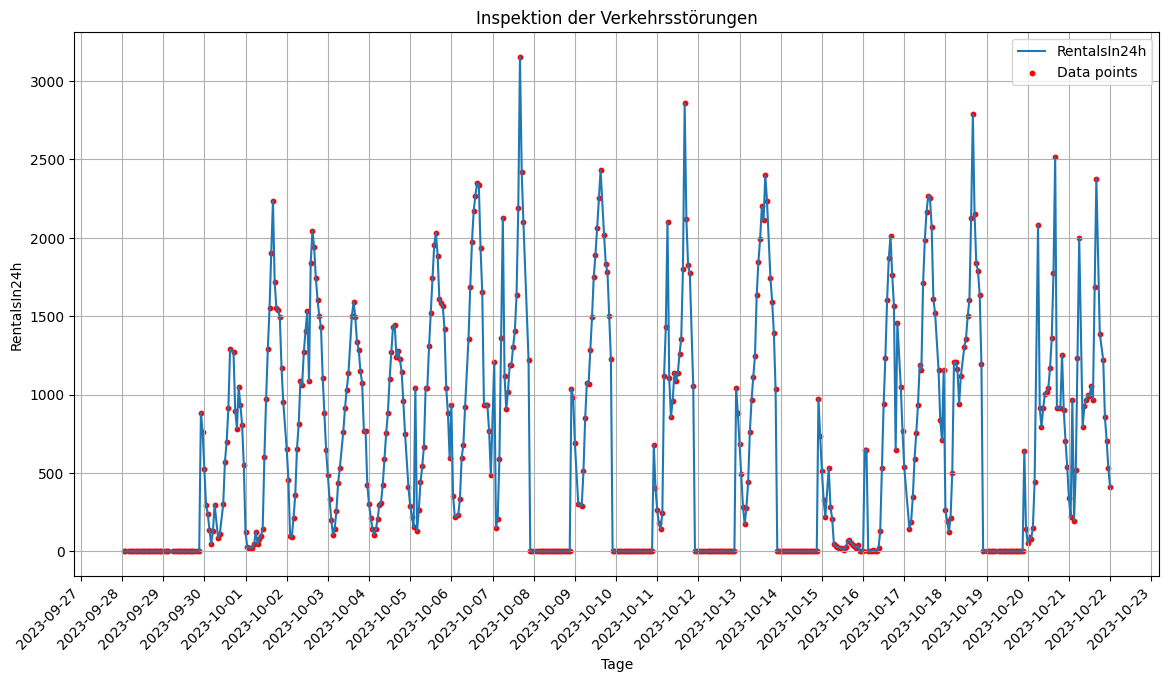

In [352]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_time_dependent_correlation(dfi, target_column):

    df = dfi.copy()
    
    def filter_time_range(dfi, start_date, end_date):

        df = dfi.copy()
        # Ensure 'Datum [Tag und Stunde]' is a datetime index
        if df.index.name != 'Datum [Tag und Stunde]':
            df.set_index('Datum [Tag und Stunde]', inplace=True)
        df.index = pd.to_datetime(df.index)

        # Filter for the specified time range
        filtered_data = df.loc[start_date:end_date]
        
        return filtered_data

    start_date = '2023-09-28'
    end_date = '2023-10-22'
    df = filter_time_range(df, start_date, end_date)
    # Ensure 'Datum [Tag und Stunde]' is a datetime index
    if df.index.name != 'Datum [Tag und Stunde]':
        df.set_index('Datum [Tag und Stunde]', inplace=True)
    df.index = pd.to_datetime(df.index)

    # Filter for the specified months (September and October)
    filtered_data_month = df[(df.index.month == 9) | (df.index.month == 10)]
    
    # Plot the target column's values for the specified months
    plt.figure(figsize=(14, 8))
    
    plt.plot(filtered_data_month.index, filtered_data_month[target_column], label=target_column)
    plt.scatter(filtered_data_month.index, filtered_data_month[target_column], color='red', s=10, label='Data points')
    
    plt.title(f'Inspektion der Verkehrsstörungen')
    plt.xlabel('Tage')
    plt.ylabel(target_column)
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Formatting x-axis ticks to show every single day
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Automatically format date labels to fit
    plt.gca().tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels by 45 degrees

    plt.show()


plot_time_dependent_correlation(train_data, new_target_variable)


### Auswertung und Implikationen explorative Datenanalyse
Histogramme:

1. Die Eingangswerte besitzen alle samt verschiedene Skalierungen --> Normalisierung der Werte notwendig, da viele Machine Learning Alorithmen empfindlich (Präzision als auch Rechenzeit) auf verschieden skalierte Inputs reagieren
2. Sichtweite, Sonneneinstrahlung, Regenmenge, Schneemenge ist ungleich verteilt: --> log Skala oder Wurzel der Merkmale
3. Bei Verkehrslage = Sperrung fällt der Wert immer auf 0: --> genauere Betrachtung mittels Plot

Zeitverlauf:

1. Es zeigen sich klare Trends bezüglich der Tageszeiten und Monate
2. 24h Täglicher Durchschnitt sowie Wochenschnitt zeigen logischerweise eine Tendenz, können jedoch nicht die extremen Ausschläge der stündlichen Werte abbilden 
3. Es gibt teilweise extreme Spitzen im Verbrauch, Peaks sind prinzipiell schwierig --> log Skala für Zielvariable (muss später wieder rückgängig gemacht werden!)
4. Nach abgleich mit einer Online Resource (https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset/code) kann man davon ausgehen, dass es sich bei den aktuellen Tagen Dienstag & Mittwoch um Samstag & Sonntag handelt --> entsprechendes Re-Mapping durchführen? --> Nein, da es bei Dummy Variablen keine Rolle spielt --> Aber: neues Feature "Weekday Yes/No"
5. Die Peaks treten immer um 6 und 16 Uhr auf --> neues Feature "Morning Peak Hour" und "Evening Peak Hour" (zwei, da sich die Peaks erheblich unterscheiden)

--> Einsatz von Features auf Basis der Tageszeit, Monate, sowie Wochentagen notwendig
--> Eine weitere Vermutung ist, das sobald es einmal an einem Tag geregnet hat die Bereitschaft sinkt, ein Fahrrad zu mieten 

Verkehrsstörungen:

1. Die Störungen treten unregelmäßig auf
2. Es scheint Peaks vor jeder Sperrung zu geben, allerdings liegen nicht genug Störungen vor um dies entgültig zu beweisen
3. Die Werte 'springen' vom Trend nach null, anschließend sofort wieder auf das zu erwartende Niveau, folgen also dem Trend
4. Es scheint also, als hätten diese geringe bis keine Auswirkungen auf die Werte vor und nach der Störungen --> Ersatz des Zielwerts 'Anzahl ausgeliehener Fahrräder' mittels ``KNNImputer``, danach drop der betreffenden Spalte

*Auch wenn dies wage Annahmen sind, so liegen aktuell keine weiteren Informationen vor um das Phänomen zu untersuchen.*


In [353]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import KNNImputer

def data_transformation_pipeline(dfi, target_variable = None):
    
    df = dfi.copy()
    
    df.set_index('Datum [Tag und Stunde]', inplace=True)
    df.index = pd.to_datetime(df.index, errors='coerce')
    

    # Zusatzfeatures
    # Create a new column 'Regentag' which is 1 if there is any 'Regenmenge [mm]' on that day, else 0
    df['Regentag'] = df['Regenmenge [mm]'].groupby(df.index.date).transform(lambda x: 1 if x.sum() > 0 else 0)
    columns_for_reorder = df.columns.to_list()

    # für Zeit und Datum
    df['Stunde'] = df.index.hour
    df['Tag'] = df.index.day
    df['Monat'] = df.index.month
    df['Wochentag'] = df.index.weekday

    # Create dummy variable templates and select target columns
    # dummy_vorlage_Monat = [f"Monat_{i+1}" for i in range(12)]
    df.drop(columns=['Monat'], inplace=True)
    dummy_vorlage_Jahreszeit = [f"Jahreszeit_{i+1}" for i in range(4)]
    dummy_columns = ['Jahreszeit','Stunde','Tag','Wochentag']

    df = pd.get_dummies(df, columns=dummy_columns, drop_first=False)

    dummy_columns_full = dummy_vorlage_Jahreszeit #+ dummy_vorlage_Monat
    for column in dummy_columns_full:
        if column not in df.columns:
            df[column] = 0.0

    for column in df.columns:
        if column.startswith(tuple(dummy_columns)):
            df[column] = df[column].astype(float)

    # Reorder the insanely complicated dummy variable operation result
    desired_order = columns_for_reorder  + dummy_vorlage_Jahreszeit #+ dummy_vorlage_Monat
    df = df.reindex(columns=desired_order)
                
    # Erstellen von Lag-Features für die letzten Stunden
    lag_features = []
    for lag in range(1, 25):
        lag_name = f'Lag_{lag}h'
        df[lag_name] = df[target_variable].shift(lag)
        lag_features.append(lag_name)

    # Log-Transformation für ungleich verteilte Merkmale
    for feature in ['Sichtweite [m]', 'Sonneneinstrahlung [Lux]', 'Regenmenge [mm]', 'Schneemenge [mm]']:
        df[feature] = np.log1p(df[feature])

    for lag_feature in lag_features:
        df[lag_feature] = np.log1p(df[lag_feature])

    # Ausgleich der leeren Werte bei Verkehrsstörungen mittels KNN Imputation
    saved_index = df.index
    imputer = KNNImputer(n_neighbors=5)

    # For consistency this column will only be edited during training
    # if train_mode:
    #     df.replace({target_variable: 0.0}, np.nan, inplace=True)
        
    # Es werden hierbei auch andere Features mittels KNN Imouter gefüllt!!
    df.drop(columns=['Jahreszeit'], inplace=True)
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    # df.drop(columns=['Verkehrslage [Normal=1/Sperrungen=0]'], inplace=True)
    df[target_variable] = df[target_variable].round(0)
    # Restore the index after imputation
    df.index = saved_index
    df.index = pd.to_datetime(df.index, errors='coerce')

    # if train_mode:
    #     print("shape BEFORE outliers removal :",df.shape)
    #     Q1 = df['Anzahl ausgeliehener Fahrräder'].quantile(0.25)
    #     Q3 = df['Anzahl ausgeliehener Fahrräder'].quantile(0.75)
    #     IQR = Q3 - Q1

    #     # Define bounds for the outliers
    #     lower_bound = Q1 - 1.5 * IQR
    #     upper_bound = Q3 + 1.5 * IQR
    #     # Identify the outliers
    #     outliers = df[(df['Anzahl ausgeliehener Fahrräder'] < lower_bound) | (df['Anzahl ausgeliehener Fahrräder'] > upper_bound)].head(40)
    #     display(outliers.style.background_gradient(cmap='Greys'))
    #     #removing outliers
    #     df = df[(df['Anzahl ausgeliehener Fahrräder'] >= lower_bound) & (df['Anzahl ausgeliehener Fahrräder'] <= upper_bound)]
    #     print("shape AFTER outliers removal :",df.shape)

    # Apply StandardScaler only to float columns
    float_columns = df.select_dtypes(include=['float64']).columns
    protect_columns = [
        'Regentag',
        'Verkehrslage [Normal=1/Sperrungen=0]',
        'Ferienzeit [Ja=1/Nein=0]',
        'Anzahl ausgeliehener Fahrräder',
        target_variable,
        ]
    
    float_columns = [
        col for col in float_columns if col != target_variable and col not in protect_columns and col.split('_')[0] not in [
            s.split('_')[0] for s in dummy_columns
            ]
        ]
    scaler = StandardScaler()
    df[float_columns] = scaler.fit_transform(df[float_columns])
    df['Weekend'] = df.index.dayofweek.isin([1, 2]).astype(float)
    # Add 'Rushhour' column: 1 if hour is 6 or 16 and weekend is 0, otherwise 0
    df['Morning_Rushhour'] = ((df.index.hour.isin([6])) & (df['Weekend'] == 0)).astype(float)
    df['Evening_Rushhour'] = ((df.index.hour.isin([16])) & (df['Weekend'] == 0)).astype(float)
    return df

train_data_pipelined = data_transformation_pipeline(train_data, target_variable=new_target_variable)
# display(train_data_pipelined)

_Ausreißer in der Zielvariable wurden zwar Bereinigt mittels der Quantile, jedoch wirkte sich dies sogar negativ auf den MSE aus_

### Zusammenfassung der Datenpipeline:

- Setzt den Index auf das Datum und die Stunde und konvertiert ihn in einen DateTime-Index
- Erzeugt das Feature 'Regentag', das angibt, ob an einem Tag Regen gemessen wurde
- Erstellt Zeit- und Datumsbezogene Features wie Stunde, Tag und Wochentag
- Erzeugt Dummy-Variablen für Jahreszeiten, Stunden, Tage und Wochentage
- Erstellt Lag-Features für die letzten 24 Stunden
- Wendet eine Log-Transformation auf bestimmte Merkmale an, um ungleich verteilte Daten anzupassen
- Füllt fehlende Werte in bestimmten Features mit KNN Imputation aus
- Wendet eine Standardisierung auf numerische Features an, außer auf geschützte und Dummy-Variablen
- Erzeugt zusätzliche Features wie 'Weekend', 'Morning_Rushhour' und 'Evening_Rushhour' basierend auf dem Zeitstempel

In [354]:
test_data_pipelined  = data_transformation_pipeline(test_data, target_variable=new_target_variable)

# Modellauswahl

Wichtige Adaption der Outputs mittels `manual_prediction_adaption`: der Output muss >= 0 und eine Ganzzahl sein !

In [355]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

def manual_prediction_adaption(prediction_values,df):

    # condition = df['Verkehrslage [Normal=1/Sperrungen=0]'] == 0
    # prediction_values[condition] = 0
    prediction_values = np.clip(prediction_values, a_min=0, a_max=None)
    prediction_values = np.round(prediction_values).astype(int)

    # condition = (df['Morning_Rushhour'] == 1.0) | (df['Evening_Rushhour'] == 1.0)
    # prediction_values[condition] *= 1.5

    return prediction_values

def plot_predicted_vs_actual(y_true,y_predictions):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_predictions, edgecolors=(0, 0, 0))
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual y-Values')
    plt.show()

def plot_model_evaluation(y_true,y_predictions):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))


    residuals = y_true - y_predictions
    sns.histplot(y_true, bins=30, kde=True, color='red', ax=ax[0])


    # Histogram of actual y values
    ax[0].set_title('Histogram der Actual Y Werte')
    ax[0].set_xlabel('Y-Werte')
    ax[0].set_ylabel('Häufigkeit')
    ax[0].grid(True)

    # QQ plot of residuals
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title('QQ-Plot der Residuen', fontsize=16, fontweight='bold')
    ax[1].set_xlabel('Theoretische Quantile')
    ax[1].set_ylabel('Beispiel-Quantile')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Plot residuals vs fitted values
    plt.scatter(y_predictions, residuals, alpha=0.2, color='r')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Best Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

    # Comparation
    plot_predicted_vs_actual(y_true, y_predictions)

    # Compute key statistics
    r_squared = r2_score(y_true, y_predictions)
    mae = mean_absolute_error(y_true, y_predictions)
    mse = mean_squared_error(y_true, y_predictions)
    rmse = np.sqrt(mse)
    n = len(y_true)

    # Print custom summary
    print(f"Linear Regression Results")
    print("="*80)

    print(f"Dep. Variable: {y_true.name if hasattr(y_true, 'name') else 'Target Variable'}")
    print(f"R-squared: {r_squared:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Root Mean Squared Error: {rmse:.3f}")
    print("="*80)


def timeline_predicted_vs_actual(y_true, y_pred, interval_month = False):
    """
    Plot a line plot of predicted vs. actual values for a specific month.
    
    Parameters:
    - y_true: pandas Series, Actual target values with DateTime index.
    - y_pred: numpy array, Predicted values from the model.
    - interval_month: int, Month number to filter and display (1 for January, 12 for December).
    """
    # Ensure input data are pandas Series with DateTime index
    if not isinstance(y_true.index, pd.DatetimeIndex):
        raise ValueError("Index of y_true must be a pandas DateTimeIndex.")
    
    # Create a pandas Series for y_pred with the same index as y_true
    y_pred_series = pd.Series(y_pred, index=y_true.index)
    
    # Filter data by the specified month
    if not interval_month:
        y_true_month = y_true
        y_pred_month = y_pred_series
    else:
        y_true_month = y_true[y_true.index.month == interval_month]
        y_pred_month = y_pred_series[y_pred_series.index.month == interval_month]
    
    # Ensure that the lengths of y_true_month and y_pred_month are the same
    if len(y_true_month) != len(y_pred_month):
        raise ValueError("The length of y_true and y_pred data for the specified month does not match.")
    
    # Create a plot
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    plt.plot(y_true_month.index, y_true_month, label='Actual Values', color='blue', linestyle='-', marker='o')
    
    # Plot predicted values
    plt.plot(y_pred_month.index, y_pred_month, label='Predicted Values', color='red', linestyle='--', marker='x')
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    if not interval_month:
        # plt.title(f'Predicted vs Actual Values')
        pass
    else:
        plt.title(f'Predicted vs Actual Values for Month {interval_month}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Root Scaling =  1
Mean Absolute Error: 206.2418650514157
Predictions: [313 276 266 224 299]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  2
Mean Absolute Error: 179.33694886603746
Predictions: [281 265 248 212 272]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  3
Mean Absolute Error: 167.23961121284674
Predictions: [277 269 249 212 274]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  4
Mean Absolute Error: 161.41569235103535
Predictions: [279 276 255 215 282]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  5
Mean Absolute Error: 160.03521622763782
Predictions: [284 285 262 220 293]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  6
Mean Absolute Error: 162.9270319763346
Predictions: [290 295 271 226 306]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  7
Mean Absolute Error: 170.60952246795316
Predictions: [298 306 281 233 320]
Actual values: [328. 308. 262. 362.  89.]
Root Scaling =  8
Mean Absolute Error: 183.11001549514015

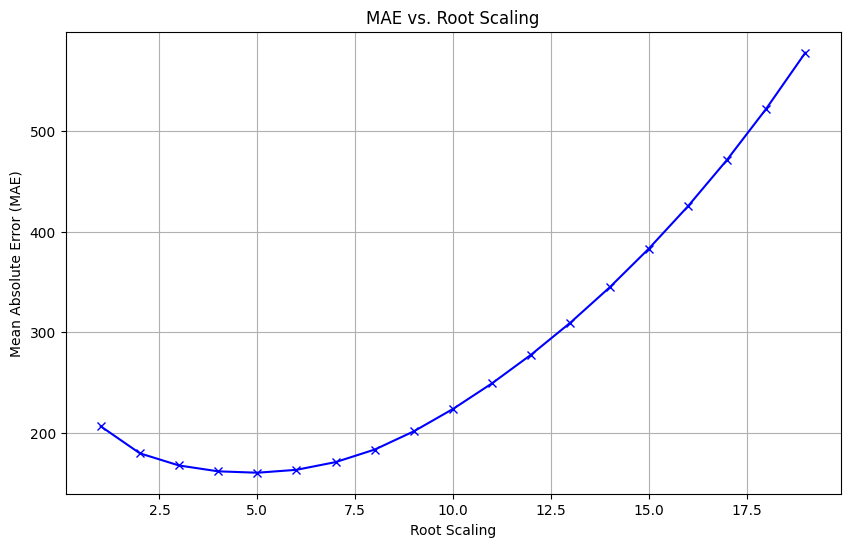

In [356]:
from sklearn.linear_model import LinearRegression

mae_vs_root = []
for r in range(1,20):
    model = LinearRegression()
    print("="*80)
    root_scaling = r
    print('Root Scaling = ',root_scaling)
    

    y_train = train_data_pipelined[new_target_variable]
    y_train = np.power(y_train, (1/root_scaling))
    X_train = train_data_pipelined.drop(columns = [new_target_variable])


    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_train)
    
    y_pred = np.power(y_pred, root_scaling)
    y_train = np.power(y_train, root_scaling)
    y_pred = manual_prediction_adaption(y_pred,X_train)

    mae = mean_absolute_error(y_train, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # Print predictions
    print('Predictions:', y_pred[:5])
    print('Actual values:', y_train.values[:5])

    mae_vs_root.append({'root': root_scaling,'mae': mae})
    # plot_model_evaluation(y_train,y_pred)

def plot_mae_vs_root(mae_vs_root):
    roots = [item['root'] for item in mae_vs_root]
    maes = [item['mae'] for item in mae_vs_root]
    
    plt.figure(figsize=(10, 6))
    plt.plot(roots, maes, linestyle='-', marker='x', color='b')
    plt.xlabel('Root Scaling')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs. Root Scaling')
    plt.grid(True)
    plt.show()

plot_mae_vs_root(mae_vs_root)



Das Testen der verschiedenen Wurzeln zeigt einen klares lokales (wahrscheninlich auch globales) Minimum (ohne Beweis) bei der 5. Wurzel mit einem durchschnittlichen absoluten Fehler.

Mean Absolute Error: 164.73193407522186
Fit der Trainingsdaten LINEARES MODELL für Monat 1


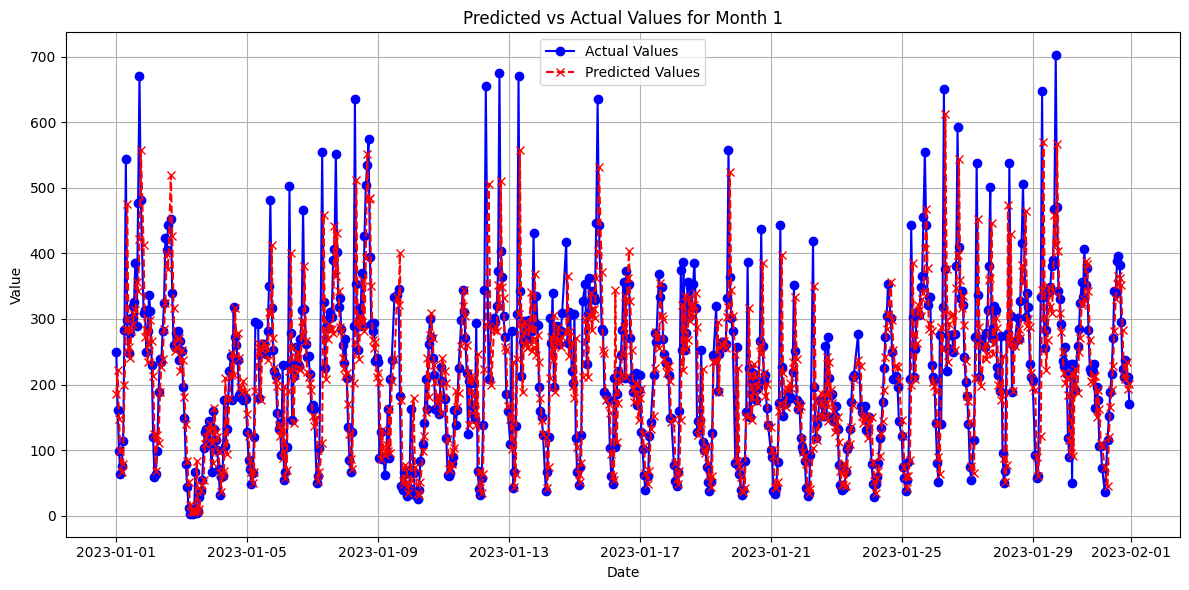

Fit der Trainingsdaten LINEARES MODELL für Monat 5


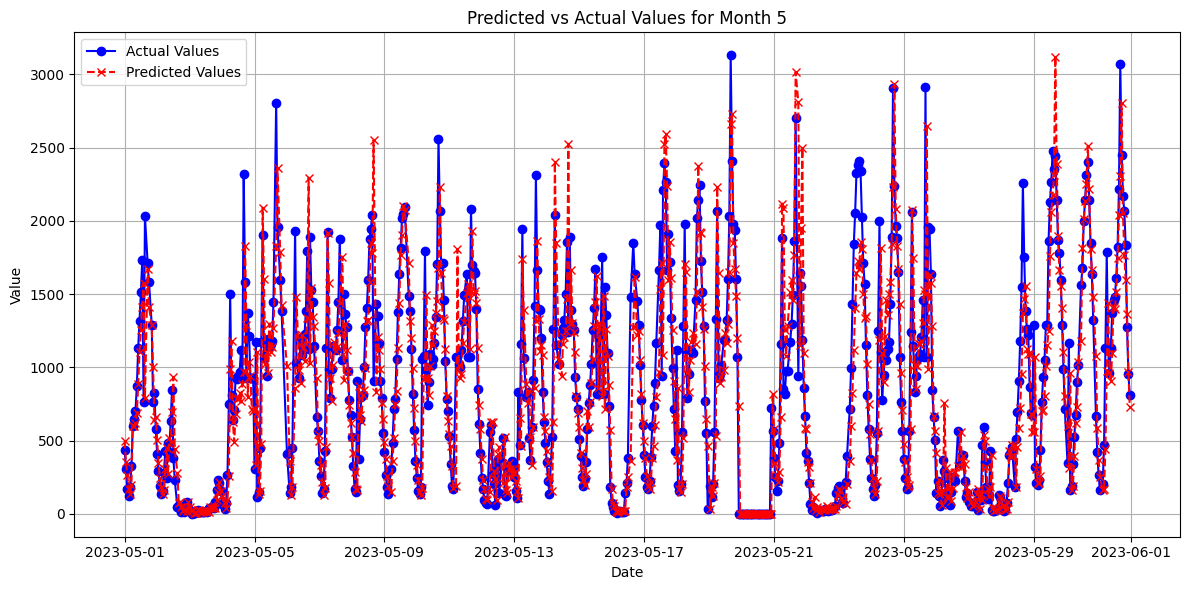

Fit der Trainingsdaten LINEARES MODELL für Monat 9


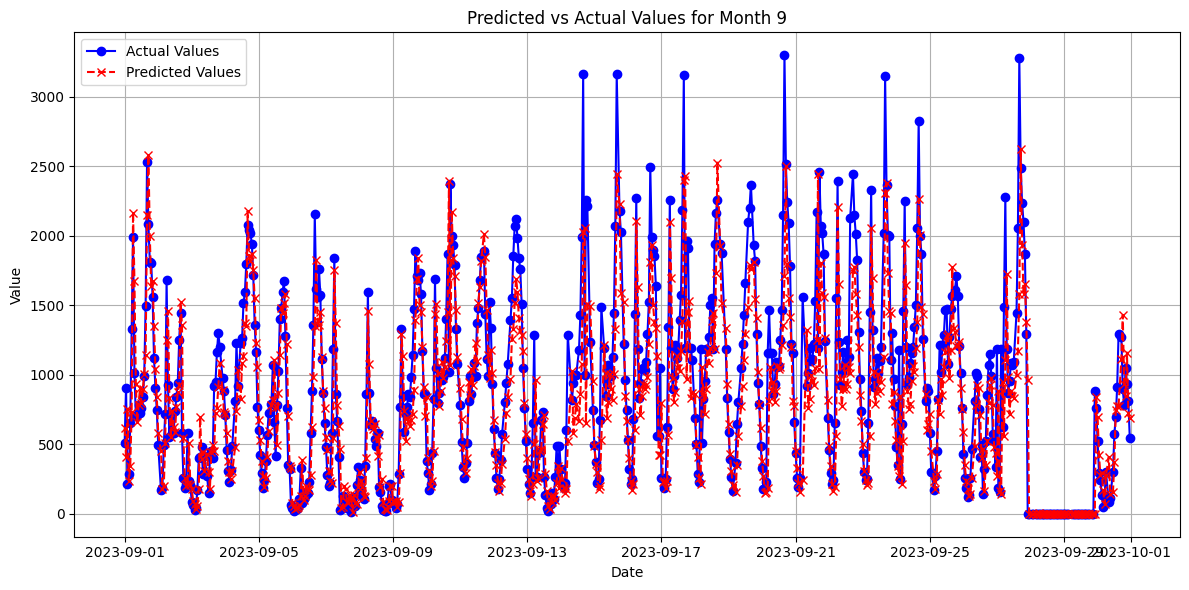

In [357]:
final_linear_model = LinearRegression()
y_train = train_data_pipelined[new_target_variable]
y_train = np.log1p(y_train)
X_train = train_data_pipelined.drop(columns = [new_target_variable])

final_linear_model.fit(X_train, y_train)

# Make predictions
y_pred = final_linear_model.predict(X_train)


# Inverse transformations
y_pred = np.expm1(y_pred)
y_train = np.expm1(y_train)
y_pred = manual_prediction_adaption(y_pred,X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Mean Absolute Error: {mae}')

# Print predictions
# print('Predictions:', y_pred[:5])
# print('Actual values:', y_train.values[:5])

for sample_month in [1,5,9]:
    print(f"Fit der Trainingsdaten LINEARES MODELL für Monat {sample_month}")
    timeline_predicted_vs_actual(y_train, y_pred, interval_month=sample_month)

Das sieht schon ziemlich dezent aus. Da die einfache Log Tranformation direkt wesentlich besser auf den Trainingsdaten performt als der MAE Wert, gegen welchen steigende Wurzeln konvergieren, wird die LOG-Skala genutzt

LINEARES MODELL
Mean Absolute Error: 312.9698046181172
BESTES MODELL LINEAR: VORHERSAGEN


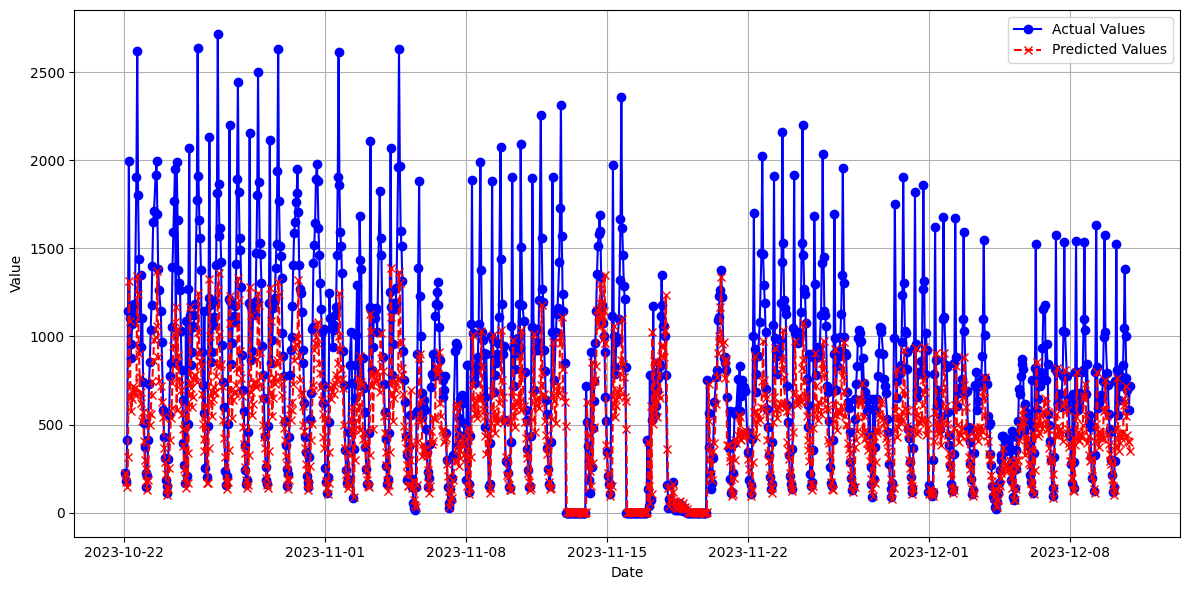

In [358]:
y_test = test_data_pipelined[new_target_variable]
y_test = np.log1p(y_test)
X_test = test_data_pipelined.drop(columns = [new_target_variable])

y_pred_test = final_linear_model.predict(X_test)

y_pred_test = np.expm1(y_pred_test)
y_test = np.expm1(y_test)
y_pred_test = manual_prediction_adaption(y_pred_test,X_test)

mae = mean_absolute_error(y_test, y_pred_test)
print(f'LINEARES MODELL')
print(f'Mean Absolute Error: {mae}')
print("BESTES MODELL LINEAR: VORHERSAGEN")
timeline_predicted_vs_actual(y_test,y_pred_test)

results_dic = {}
results_dic['linear_model'] = (y_pred_test,mae)

### Fazit Lineare Regression
- sehr schnelles Training und Vergleich unter den Modellen mit verschiedenen Skalierungen möglich
- hat starke Probleme die Nachfragepeaks darzustellen

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters: {'bootstrap': True, 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 161}
Best Score: 0.7901013537899697

Prediction time random forest: 0.029603 seconds
Mean Absolute Error: 219.65097690941386

BESTES MODELL RANDOM FOREST: VORHERSAGEN


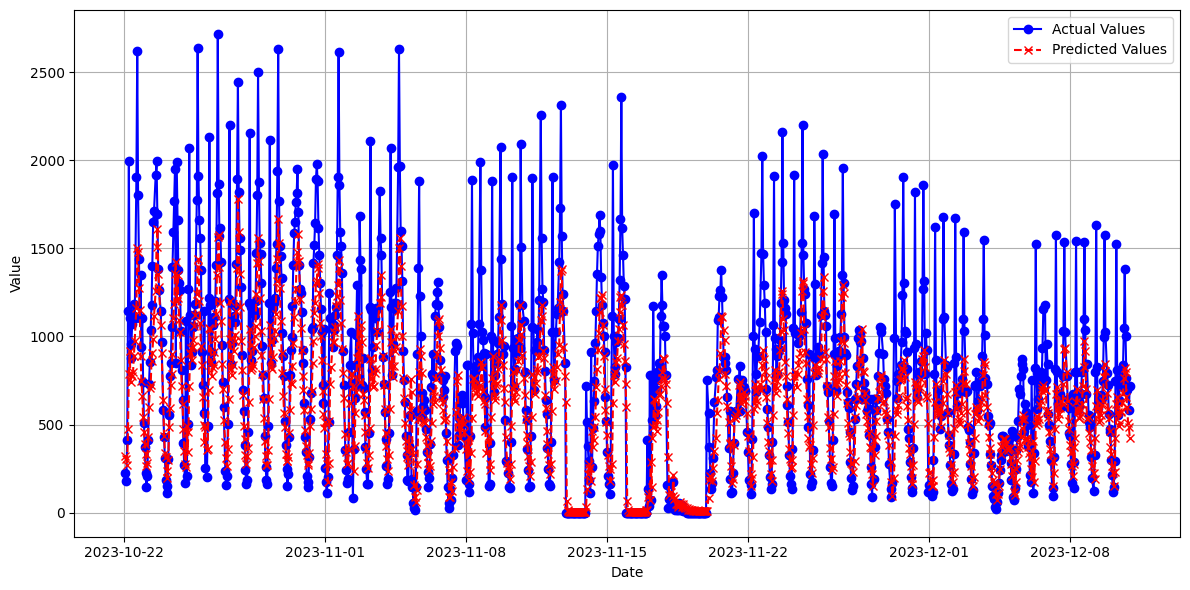

In [359]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 200),          # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': randint(3, 20),               # Maximum depth of the tree
    'min_samples_split': randint(2, 20),        # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
}

# Set up the Randomized Grid Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                   # Number of parameter settings to try
    cv=5,                        # Number of folds in cross-validation
    verbose=2,                    # Controls the verbosity
    random_state=42,              # Seed for random number generator
    n_jobs=-1                     # Number of jobs to run in parallel
)

y_train = train_data_pipelined[new_target_variable]
# y_train = np.power(y_train, (1/root_scaling))
y_train = np.log1p(y_train)
X_train = train_data_pipelined.drop(columns = [new_target_variable])

y_test = test_data_pipelined[new_target_variable]
X_test = test_data_pipelined.drop(columns = [new_target_variable])

# Fit the Randomized Grid Search
random_search.fit(X_train, y_train)

print("")
# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print("")

# Make predictions using the best model
best_rf = random_search.best_estimator_

import time
start_time = time.time()
y_pred = best_rf.predict(X_test)

# y_pred = np.power(y_pred, root_scaling)
# y_train = np.power(y_train, root_scaling)
y_pred = np.expm1(y_pred)
y_train = np.expm1(y_train)

y_pred = manual_prediction_adaption(y_pred,X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Prediction time random forest: {elapsed_time:.6f} seconds")

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}\n')

print(f"BESTES MODELL RANDOM FOREST: VORHERSAGEN")
timeline_predicted_vs_actual(y_test,y_pred)

results_dic['random_forest_model'] = (y_pred,mae)

### Fazit Random Forest
- erfasst die Peaks wesentlich besser als lineare Regression
- die Hyperparametersuche dauert zwar etwas, jedoch ist bei diesem Datensatz das fertig adjustierte Modell fast genauso schnell wie auch die lineare Regression

Epoch 1/50
345/355 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2827 - mean_absolute_error: 1.0904
Epoch 1: val_loss improved from inf to 3.88233, saving model to best_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.2609 - mean_absolute_error: 1.0843 - val_loss: 3.8823 - val_mean_absolute_error: 1.8382
Epoch 2/50
322/355 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9870 - mean_absolute_error: 0.6886
Epoch 2: val_loss improved from 3.88233 to 2.85486, saving model to best_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9803 - mean_absolute_error: 0.6853 - val_loss: 2.8549 - val_mean_absolute_error: 1.5477
Epoch 3/50
346/355 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7661 - mean_absolute_error: 0.5895
Epoch 3: val_loss improved from 2.85486 to 2.49506, saving model to best_model.keras
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7655 - mean_absolute_error: 0.5892 - val_loss: 2.4951 - val_mean_absolute_error: 1.4415
Epoch 4/50
323/355 ━━━━━━━━━━━━━━━━━━━━ 0

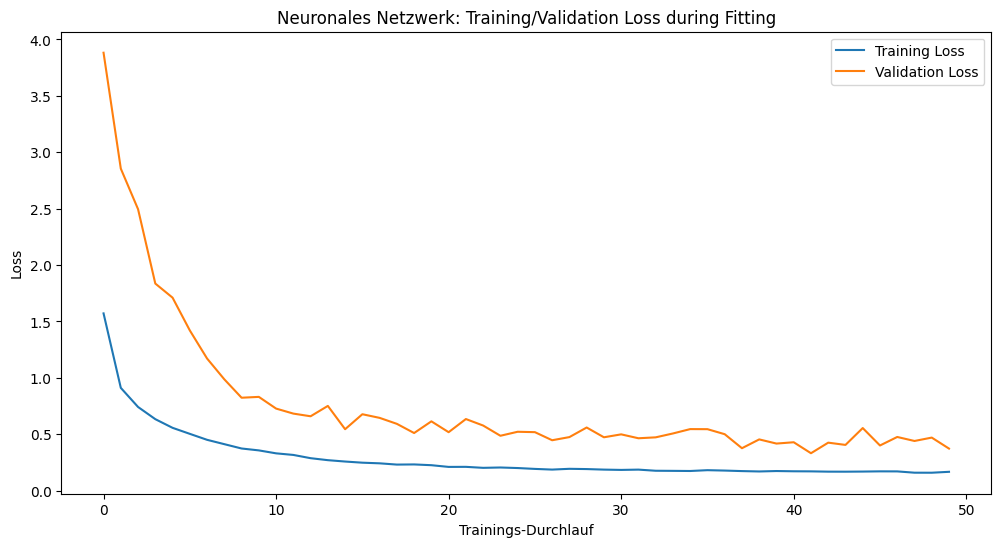

BESTES MODELL NEURONALES NETZWERK: VORHERSAGEN


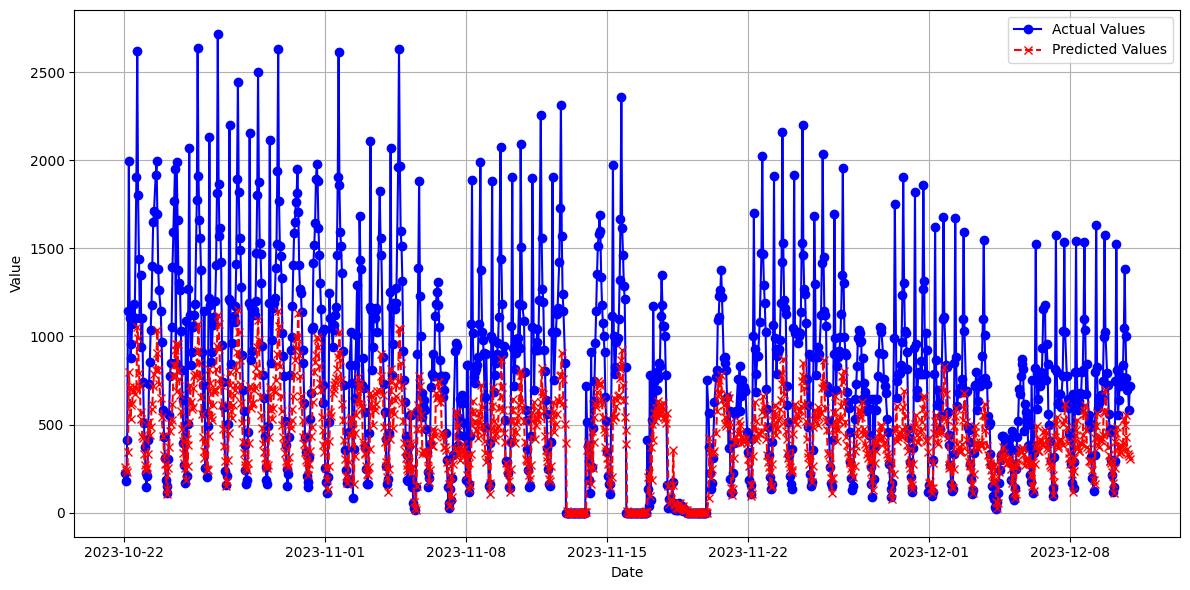

In [360]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

root_scaling = 5

# Transform input
y_train = train_data_pipelined[new_target_variable]
# y_train = np.log1p(y_train)
y_train = np.power(y_train, (1/root_scaling))
X_train = train_data_pipelined.drop(columns = [new_target_variable])
X_train['Anzahl ausgeliehener Fahrräder'] = np.log1p(X_train['Anzahl ausgeliehener Fahrräder'])
        
y_test = test_data_pipelined[new_target_variable]
X_test = test_data_pipelined.drop(columns = [new_target_variable])
X_test['Anzahl ausgeliehener Fahrräder'] = np.log1p(X_test['Anzahl ausgeliehener Fahrräder'])

# Define the Neural Network model
nn_model = Sequential([
    Dense(train_data_pipelined.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout layer with 50% dropout rate
    Dense(200, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout layer with 50% dropout rate
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.5),  # Dropout layer with 50% dropout rate
    # Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout layer with 50% dropout rate
    Dense(1, kernel_regularizer=l2(0.001))  # Output layer for regression
])

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Filepath where the model will be saved
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize the monitored quantity
    verbose=1                  # Print messages when saving the model
)

# Compile the model
# nn_model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error'])

# # Train the model
# history = nn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model with the checkpoint callback
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint_callback],  # Add the checkpoint callback here
    verbose=1
)

best_model = load_model('best_model.keras')

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Make predictions
# y_pred = nn_model.predict(X_test)

y_pred = np.power(y_pred, root_scaling)
# y_train = np.expm1(y_train)
y_train = np.power(y_train, root_scaling)
y_pred = manual_prediction_adaption(y_pred,X_test)
# y_pred = np.expm1(y_pred)
# y_train = np.expm1(y_train)

# Calculate Mean Absolute Error
y_test_clean = np.nan_to_num(y_test, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
y_pred_clean = np.nan_to_num(y_pred, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
mae = mean_absolute_error(y_test_clean, y_pred_clean)
print(f'Mean Absolute Error: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neuronales Netzwerk: Training/Validation Loss during Fitting')
plt.xlabel('Trainings-Durchlauf')
plt.ylabel('Loss')
plt.legend()
plt.show()

# display(y_pred)
results_dic['neural_network'] = (y_pred,mae)

print("BESTES MODELL NEURONALES NETZWERK: VORHERSAGEN")
timeline_predicted_vs_actual(y_test,y_pred.flatten())


### Fazit Neuronales Netzwerk
Auch nach längerem herumprobieren mit Regularisierung, Callback Funktionen oder Adjustierung der Hyperparameter konnte kein wesentlich besseres Ergebnis als mit der linearen Regression erreicht werden. Es existiert meist ein Gap zwischen Validierungs-Loss und Trainings-Loss welches auf ein leichtes Overfitting hindeuted.

# Quantitativer Vergleicher der Modelle
Durch die starke Fluktuation der Werte werden wir den Verallgemeinerungsfehler mittels eines 95% Konfidenzintervalls messen.

In [361]:
from scipy import stats

for key, values in results_dic.items():
    print("Model :", key)
    print("Mean Absolute Error:", round(values[1]))
    confidence = 0.95
    try:
        squared_errors = (values[0] - y_test) ** 2
    except ValueError:
        squared_errors = (values[0].flatten() - y_test) ** 2
    std_err = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(),scale=stats.sem(squared_errors)))
    print(f"Standard Error for {key}: {np.round(std_err)}")
    print("="*80)

Model : linear_model
Mean Absolute Error: 313
Standard Error for linear_model: [412. 459.]
Model : random_forest_model
Mean Absolute Error: 220
Standard Error for random_forest_model: [310. 356.]
Model : neural_network
Mean Absolute Error: 369
Standard Error for neural_network: [470. 519.]


- Das neuronale Netzwerk zeigt den niedrigsten MMAE, was darauf hinweist, dass es die besten Vorhersagen im Vergleich zu den tatsächlichen Werten liefert
- Das Random Forest Modell hat einen etwas höheren MAE, ist aber immer noch besser als das lineare Modell
- Das lineare Modell hat den höchsten MAE, was bedeutet, dass seine Vorhersagen im Durchschnitt am weitesten von den tatsächlichen Werten entfernt sind


- Die Standardfehler (Konfidenzintervalle) geben uns eine Vorstellung von der Unsicherheit in den Fehlerabschätzungen der Modelle. Das lineare Modell hat das breiteste Konfidenzintervall, was auf eine höhere Unsicherheit in seinen Fehlerabschätzungen hinweist, während das Random Forest Modell das engste Intervall hat.

### Peaks
Trotz speziellem Feature Engineering bezüglich der Nachfragepeaks hatten alle drei Modelle Problem mit der korrekten Modellierung der Peaks, speziell bei den Testdaten. 

# Qualitativer Vergleich der Modelle auf Basis der Testdaten

**Lineare Regression**
- sehr einfach zu interpretieren, wir könnten die einzelnen Koeffizienten ausdrucken und analysieren (jedoch hier kein Teil der Aufgabe)
- skaliert linear mit O(n) --> das `fit()` des Modells geht sehr schnell --> wir könnten auch wesentlich größere Datensätze in unser Modell einspeisen
- Voraussetzung: teilweise intensives Feature Engineering um nicht-lineare Zusammenhänge im Datensatz auszugleichen

**Random Forest**
- die zugrunde liegenden Decision Trees sind allgemein ebenfalls gut interpretierbar, der Random Forest als Gesamtheit ist bereits stark abstrahiert
- skaliert mit O(M * n * log(n)) --> für größere Datensätze wird mehr Rechenzeit benötigt, speziell wenn viele Features existieren
- auch ohne viel Feature Engineering sind nicht-lineare Zusammenhänge abbildbar
- mittels GridSearch oder RandomizedSearch lassen sich schnell und einfach die korrekten Hyperparameter finden

**Neuronale Netzwerke**
- konkrete Kausalitäten im Modell für Laihen sehr schwer zu interpretieren
- durch iteratives Training sehr Rechenzeitintensiv (starke GPU notwendig) --> neue Dateninputs für das Modell müssen gut geplant werden
- neigen zu Overfitting (hier: "auswendig lernen" der Trainingsdaten) --> geschickte Regularisierungstechniken notwendig
- ausgiebiges, zeitintensives Hyperparameter-Tuning notwendig um _wirklich_ gute Ergebnisse zu erhalten

## Auswahl eines Modells
Da der potenzielle Kunde des Modells vermutlich ein Fahrradverleihunternehmen aus dem Mittelstand ist, überzeugen die Eigenschaften der **Random Forest**. Ausschlaggebender Punkte:
- geringe Rechenressourcen
- einfache Handhabung und Interpretierbarkeit